### EIGENSTRAT

Goal: To examine patterns of population structure in duplicated loci.

### Bring:
1. *.haplotypes.tsv file (produced by [Stacks](http://creskolab.uoregon.edu/stacks/))
    * used for dominant coding of each allele

2. genotype file in *.ped format
    * normal codominant genotypes of biallelic SNPs, used to compare 
    

### Take away:
* PCAs of genetic data:
    - full data coded as codominant genotypes (normal bi-allelic SNPs)
    - full data coded as dominant alleles
    - paralogs coded as dominant alleles

### Programs used:
* [EIGENSOFT](http://www.hsph.harvard.edu/alkes-price/software/) (specifically SMARTPCA)
 - Patterson N, Price AL, Reich D (2006) Population Structure and Eigenanalysis. PLoS Genet 2(12): e190. doi: 10.1371/journal.pgen.0020190
    
### Steps
1. a
2. b
3. c

#### Python imports

In [2]:
import collections
import numpy as np
import pandas as pd
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import seaborn as sns

#### Plot formatting

In [3]:
sns.set(font_scale=2)
sns.set_style("white")
%matplotlib inline

#### Dominance coding
Haplotypes is a class to store the haplotypes assigned to a group of indidividuals at a particular catalog ID.  Each catalog ID is split into one 'locus' per observed haplotyped.  These loci are named as "catID_haplotype"

Genotypes of these dominant loci are scored as: 
    - 1 = allele is present
    - 0 = allele is absent
    - 9 = no call

In [4]:
class Haplotypes(object):
    def __init__(self, catID, ind_names, haplotypes, missing_codes = ["", "-", "No Call", 'Invalid', 'consensus']):
        self.catID = catID
        self.missing_codes = missing_codes
        self.haplotype_of_ind = collections.OrderedDict(zip(ind_names, haplotypes))
        self.set_alleles()
        self.split_catID_haplotypes()
        
    def set_alleles(self):    
        seen = set()
        for ind, haplo in self.haplotype_of_ind.items():
            if haplo in self.missing_codes:
                haplo = "-"
            else:
                haplo_set = frozenset(haplo.split("/"))
                for allele in haplo_set:
                    if allele not in self.missing_codes:
                        seen.add(allele)
        self.alleles = seen
        
    def split_catID_haplotypes(self):
        self.dom_coding_of_allele = dict()
        for allele in self.alleles:
            dom_coding = list()
            for xx in self.haplotype_of_ind.values():
                if xx is '-':
                    dom_coding.append(9)
                elif allele in xx.split('/'):
                    dom_coding.append(1)
                else:
                    dom_coding.append(0)
            self.dom_coding_of_allele['{}_{}'.format(self.catID, allele)] = dom_coding      

Trying out the Haplotypes class

In [5]:
INDNAMES = ['CMHAMM10_0002','CMHAMM10_0005','CMHAMM10_0008','CMHAMM10_0011','CMHAMM10_0012',
            'CMHAMM10_0014','CMHAMM10_0015','CMHAMM10_0016', 'CMHAMM10_0017','CMHAMM10_0018','CMHAMM10_0022',
            'CMHAMM10_0024']
HAPLOS = ['GG/TA','GG/TA','GG/TT','GG/TA','GG/TA','GG/TA','GG/TA','GG/TA','GG/TA','GG/TA','GG/TA','-']

AA = Haplotypes(catID='01', ind_names=INDNAMES, haplotypes=HAPLOS)

for ind, haplotypes in AA.haplotype_of_ind.items():
    print ind, haplotypes

for locus, genotypes in AA.dom_coding_of_allele.items():
    print locus, genotypes

CMHAMM10_0002 GG/TA
CMHAMM10_0005 GG/TA
CMHAMM10_0008 GG/TT
CMHAMM10_0011 GG/TA
CMHAMM10_0012 GG/TA
CMHAMM10_0014 GG/TA
CMHAMM10_0015 GG/TA
CMHAMM10_0016 GG/TA
CMHAMM10_0017 GG/TA
CMHAMM10_0018 GG/TA
CMHAMM10_0022 GG/TA
CMHAMM10_0024 -
01_TT [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 9]
01_GG [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 9]
01_TA [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 9]


#### creating the input files for EIGENSOFT
- haplotypes_in = haplotypes.tsv (from Stacks)

- indiv_in = ped file of the individuals to retain

- catID_in = map or snplist file of the catIDs to retain

In [6]:
def write_dom_EIGENSTRAT_files(haplotypes_in, ind_in, catID_in, genotype_out, map_out):
    with open(ind_in) as ind_INFILE:
        ind_to_keep = [line.split()[1] for line in ind_INFILE]
        print('Inds to keep: {}'.format(len(ind_to_keep)))

    with open(catID_in) as catID_INFILE:
        try: # this works on map files - catId is found by spliting the snpID
            catId_to_keep = [line.split()[1].split('_')[0] for line in catID_INFILE]
        except IndexError: # this works on snplist files - each line is a catID to keep
            catId_to_keep = [line.strip() for line in catID_INFILE]
        print('catIds to keep: {}'.format(len(catId_to_keep)))

    with open(haplotypes_in) as INFILE:
        HEADER = next(INFILE)
        ind_names = HEADER.strip().split('\t')[2:]
        ind_keeps = [xx in ind_to_keep for xx in ind_names]
        kept_names = [xx for xx in ind_names if xx in ind_to_keep]
        with open(genotype_out, 'w') as geno_OUTFILE:
            with open(map_out, 'w') as map_OUTFILE:
                for line in INFILE:
                    catID = line.split('\t')[0]
                    if catID in catId_to_keep:
                        haplos = line.strip().split('\t')[2:]
                        kept_haplos = [xx for (cnt,xx) in enumerate(haplos) if ind_keeps[cnt]]
                        haps = Haplotypes(catID, kept_names, kept_haplos)
                        for allele, calls in haps.dom_coding_of_allele.items():
                            geno_OUTFILE.write(''.join([str(xx) for xx in calls]))
                            geno_OUTFILE.write('\n')
                            map_OUTFILE.write('1\t{}\t1\t1\n'.format(allele))
            

#### All mapped loci

In [7]:
write_dom_EIGENSTRAT_files(
    haplotypes_in = '/home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/all.haplotypes.tsv',
    ind_in = '/home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.ped',
    catID_in = '/home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.map',
    genotype_out = '/home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.dom.tsv',
    map_out = '/home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.dom.map')

Inds to keep: 174
catIds to keep: 6941


#### Just the mapped paralogs

In [8]:
write_dom_EIGENSTRAT_files(
    haplotypes_in = '/home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/all.haplotypes.tsv',
    ind_in = '/home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.ped',
    catID_in = '/home/ipseg/Desktop/waples/chum_populations/linkage_map/chum_paralogs.txt',
    genotype_out = '/home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/paralogs.dom.tsv',
    map_out = '/home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/paralogs.dom.map')

Inds to keep: 174
catIds to keep: 2896


## Run Smartpca
Smartpca, within EIGENSOFT, is used for PCA analysis. Smartpca uses a parameter file to specify program options.

#### Notes

   * You may need to check your in input \*.map files, EIGENSOFT is excluding loci on chr=0.  If you want to retain unplaced loci, set chr (column 1) to 1.

   * smartpca also complains about the  6th column of the .ped file (phenotype) when the value is '-9' (ie. missing).  We can set this to 1 or 0 to remove this error, specifing cases or controls. see [FAQ](http://www.hsph.harvard.edu/alkes-price/eigensoft-frequently-asked-questions/)
   * Patterson (2006) notes that the normalization ('usenorm') should **not** be applied to dominance-coded data.


In [9]:
SMARTPCA_path = '/home/ipseg/Programs/EIGENSOFT/EIG6.0.1/bin/smartpca'

#### write parfile(s)

In [ ]:
def function_to_write_parfiles(base_dir):
    ## TODO
    pass

In [10]:
on_map_dom_PARFILE_path = '/home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.parfile'

with open(on_map_dom_PARFILE_path, 'w') as OUTFILE:
    OUTFILE.write('''\
genotypename:  /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.dom.tsv
snpname:       /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.dom.map
indivname:       /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.ped

evecoutname:    /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.dom.evec
evaloutname:    /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.dom.eval
grmoutname:      /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.dom.rel
snpweightoutname: /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.dom.snpweights
deletesnpoutname: /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.dom.snpremoved
outlieroutname: /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.dom.ind_outliers

fastmode:      NO
usenorm:       NO
missingmode:   NO
outliermode:   0 
numchrom:      50
numoutlieriter: 5 
numoutlierevec: 10 
lsqproject: NO \
    ''')


In [11]:
paralogs_dom_PARFILE_path = '/home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/paralogs.parfile'

with open(paralogs_dom_PARFILE_path, 'w') as OUTFILE:
    OUTFILE.write('''\
genotypename:  /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/paralogs.dom.tsv
snpname:       /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/paralogs.dom.map
indivname:       /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.ped

evecoutname:    /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/paralogs.dom.evec
evaloutname:    /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/paralogs.dom.eval
grmoutname:      /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/paralogs.dom.rel
snpweightoutname: /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/paralogs.dom.snpweights
deletesnpoutname: /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/paralogs.dom.snpremoved
outlieroutname: /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/paralogs.dom.ind_outliers

fastmode:      NO
usenorm:       NO
missingmode:   NO
outliermode:   0 
numchrom:      50
numoutlieriter: 5 
numoutlierevec: 10 
lsqproject: NO \
    ''')


In [12]:
on_map_codom_PARFILE_path = '/home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.codom.parfile'

with open(on_map_codom_PARFILE_path, 'w') as OUTFILE:
    OUTFILE.write('''\
genotypename:  /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.ped
snpname:       /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.map
indivname:       /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.ped

evecoutname:    /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.codom.evec
evaloutname:    /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.codom.eval
grmoutname:      /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.codom.rel
snpweightoutname: /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.codom.snpweights
deletesnpoutname: /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.codom.snpremoved
outlieroutname: /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.codom.ind_outliers

fastmode:      NO
usenorm:       NO
missingmode:   NO
outliermode:   0 
numchrom:      50
numoutlieriter: 5 
numoutlierevec: 10 
lsqproject: NO \
    ''')

#### call SMARTPCA

In [13]:
!{SMARTPCA_path} -p {on_map_dom_PARFILE_path} > \
 /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.dom.logfile

In [14]:
!{SMARTPCA_path} -p {paralogs_dom_PARFILE_path}> \
 /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/paralogs.dom.logfile

In [15]:
!{SMARTPCA_path} -p {on_map_codom_PARFILE_path}> \
 /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.codom.logfile

### Plot EIGENSOFT results

#### Manually color populations 

In [16]:
pop_colors = ['purply pink', 'golden', 'leaf green', 'blood', 'vomit', 'primary blue', 
              'bright sky blue', 'dark cyan', 'grey', 'red']

#### load SMARTPCA results

In [17]:
eigenvec_on_map_dom = pd.read_csv(
    '/home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.dom.evec',
    sep = ' ', skipinitialspace = True)
eigenvec_on_map_dom.columns = ['ind', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'junk']
eigenvec_on_map_dom['POP'] = [xx.split(':')[0] for xx in eigenvec_on_map_dom['ind']]
eigenvec_on_map_dom.head()

,ind,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,junk,POP
0,1:CMHAMM10_0002,0.2358,0.0412,0.0349,0.0130,-0.0244,-0.0100,0.0354,-0.0232,0.0491,-0.0568,Control,1
1,1:CMHAMM10_0005,0.1832,0.0062,0.0032,-0.0116,-0.0067,0.0655,0.0398,0.0013,-0.0195,0.0086,Control,1
2,1:CMHAMM10_0008,0.1923,0.0214,0.0473,0.0095,0.0421,0.0165,-0.0160,0.0202,0.0240,0.0001,Control,1
3,1:CMHAMM10_0011,0.1975,0.0392,0.0175,-0.0148,0.0261,0.0317,-0.0081,0.0130,-0.0581,0.0278,Control,1
4,1:CMHAMM10_0012,0.1981,0.0186,0.0073,0.0010,0.0103,-0.0176,-0.0026,0.0108,0.0029,0.0003,Control,1


In [18]:
eigenvec_paralogs = pd.read_csv(
    '/home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/paralogs.dom.evec',
                       sep = ' ', skipinitialspace = True)
eigenvec_paralogs.columns = ['ind', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'junk']
eigenvec_paralogs['POP'] = [xx.split(':')[0] for xx in eigenvec_paralogs['ind']]
eigenvec_paralogs.head()

,ind,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,junk,POP
0,1:CMHAMM10_0002,0.0805,0.1883,-0.1042,0.0589,0.0103,-0.0073,-0.0518,-0.0107,-0.0555,-0.0528,Control,1
1,1:CMHAMM10_0005,0.0651,0.1645,-0.0110,0.0443,0.0038,0.0480,-0.0348,0.2018,-0.1477,0.0135,Control,1
2,1:CMHAMM10_0008,0.0745,0.1509,-0.0587,-0.0020,-0.1045,0.0194,-0.0239,0.0099,0.1272,0.0272,Control,1
3,1:CMHAMM10_0011,0.0694,0.1218,-0.0942,-0.0799,-0.0501,0.0178,0.0579,-0.0193,0.0448,-0.0510,Control,1
4,1:CMHAMM10_0012,0.0713,0.1382,0.0195,-0.0348,0.0853,-0.0607,-0.0214,0.0060,-0.0064,-0.0178,Control,1


In [19]:
eigenvec_on_map_codom = pd.read_csv(
    '/home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.codom.evec',
    sep = ' ', skipinitialspace = True)
eigenvec_on_map_codom.columns = ['ind', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'junk']
eigenvec_on_map_codom['POP'] = [xx.split(':')[0] for xx in eigenvec_on_map_codom['ind']]
eigenvec_on_map_codom.head()

,ind,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,junk,POP
0,1:CMHAMM10_0002,0.2287,0.0408,0.0324,0.0083,-0.0250,-0.0467,0.0050,0.1188,-0.0182,-0.0646,Control,1
1,1:CMHAMM10_0005,0.1823,0.0143,-0.0080,-0.0099,0.0056,-0.0309,-0.0303,0.0018,0.0336,-0.0024,Control,1
2,1:CMHAMM10_0008,0.1949,0.0308,0.0462,0.0040,0.0699,0.0154,-0.0144,-0.0045,-0.0216,-0.0536,Control,1
3,1:CMHAMM10_0011,0.1940,0.0492,0.0322,-0.0014,0.0318,-0.0203,0.0262,-0.0715,0.0232,0.0097,Control,1
4,1:CMHAMM10_0012,0.2002,0.0287,0.0095,0.0069,0.0161,0.0440,-0.0444,-0.0385,-0.0010,-0.0277,Control,1


### Load evalues

### Plot snp weights

In [27]:
snpweights_on_map_codom = pd.read_csv(
    '/home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.codom.snpweights',
    sep = ' ', skipinitialspace = True, header = None)
snpweights_on_map_codom.columns = ['locus', 'LG', 'pos'] +  ['wPC{}'.format(x) for x in range(1,11)]
snpweights_on_map_codom.head()

,locus,LG,pos,wPC1,wPC2,wPC3,wPC4,wPC5,wPC6,wPC7,wPC8,wPC9,wPC10
0,8315_6,1,6,0.475,1.604,1.416,-2.358,2.303,-0.663,1.046,-1.339,2.719,0.602
1,36304_6,1,6,1.468,-2.741,1.136,0.196,-0.141,-1.047,0.632,-1.338,1.727,-1.267
2,41478_6,1,6,2.128,-0.612,1.534,-0.907,1.031,-0.882,-0.756,-0.740,-0.148,-0.152
3,6516_7,1,7,0.661,2.655,-1.287,-1.529,-0.710,2.529,0.819,-0.580,-0.799,-1.621
4,41929_7,1,7,-0.220,-1.047,1.348,-0.477,-0.278,1.061,-2.172,0.213,0.261,0.585


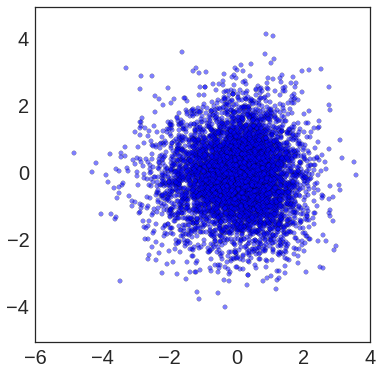

In [36]:
figsize(6,6)
plt.scatter(snpweights_on_map_codom.wPC1, snpweights_on_map_codom.wPC2, alpha = .5)
plt.show()

In [ ]:
snpweights_paralogs = pd.read_csv(
    '/home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/paralogs.dom.snpweights',
    sep = ' ', skipinitialspace = True, header = None)
snpweights_paralogs.columns = ['locus', 'LG', 'pos'] +  ['wPC{}'.format(x) for x in range(1,11)]

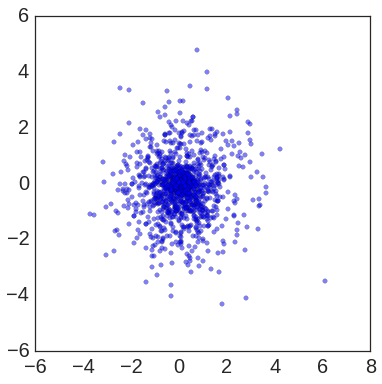

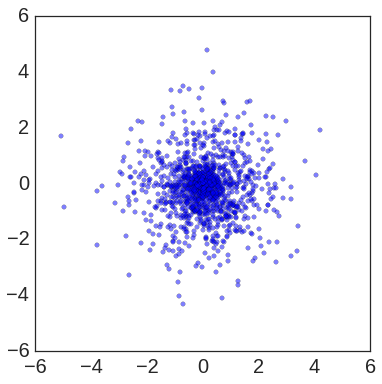

In [42]:
figsize(6,6)
plt.scatter(snpweights_paralogs.wPC1, snpweights_paralogs.wPC2, alpha = .5)
plt.show()
plt.scatter(snpweights_paralogs.wPC3, snpweights_paralogs.wPC2, alpha = .5)
plt.show()


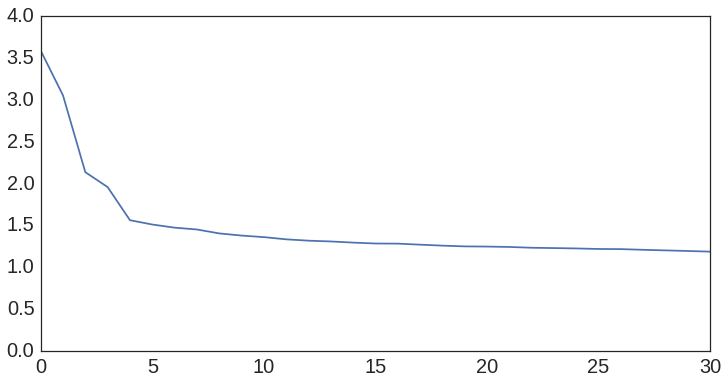

In [52]:
figsize(12,6)
evals = pd.read_csv(
    '/home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.codom.eval',
    sep = ' ', skipinitialspace = True, header = None)
evals.head()
plt.plot(evals[0])
plt.xlim(0,30)
plt.show()

#### Plot the first few PC axes for each of the data sets

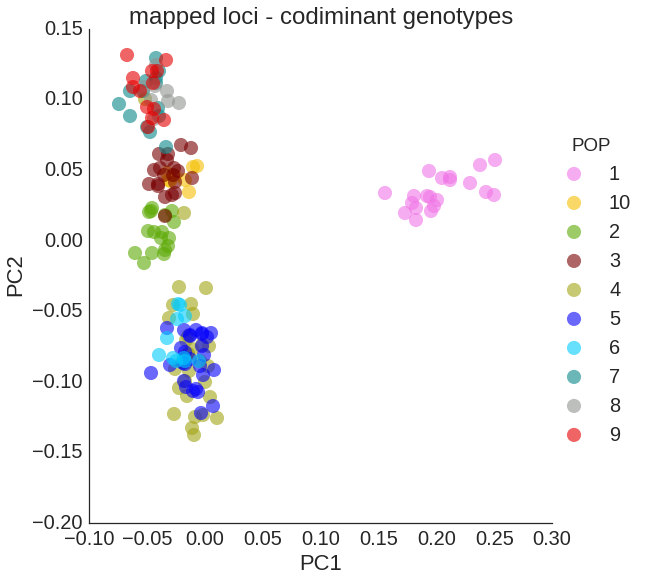

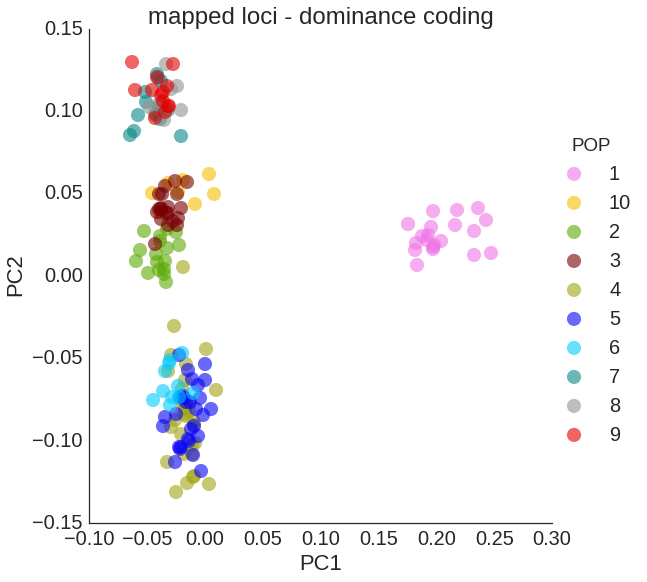

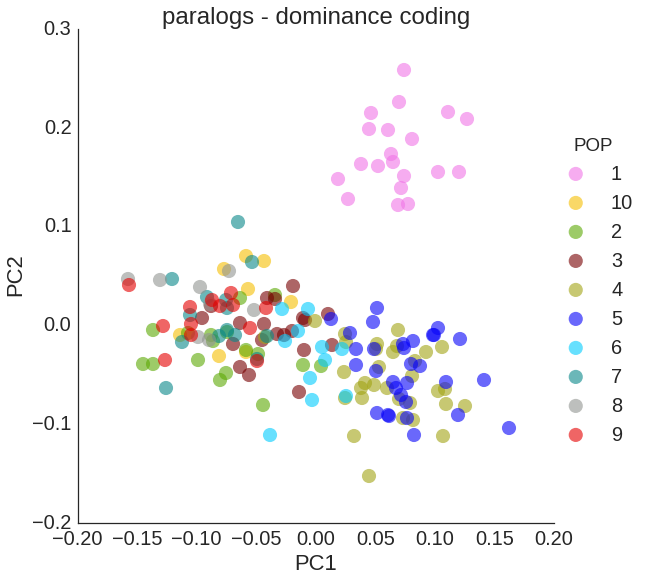

In [20]:
figsize(10, 10)

sns.lmplot('PC1', 'PC2', data= eigenvec_on_map_codom, hue = 'POP', palette=sns.xkcd_palette(pop_colors),
           fit_reg=False, size = 8, scatter_kws={"s": 200., 'alpha': .6} )
plt.title('mapped loci - codiminant genotypes')
plt.show()

sns.lmplot('PC1', 'PC2', data= eigenvec_on_map_dom, hue = 'POP', palette=sns.xkcd_palette(pop_colors),
           fit_reg=False, size = 8, scatter_kws={"s": 200., 'alpha': .6} )
plt.title('mapped loci - dominance coding')
plt.show()

sns.lmplot('PC1', 'PC2', data= eigenvec_paralogs, hue = 'POP', palette=sns.xkcd_palette(pop_colors),
           fit_reg=False, size = 8, scatter_kws={"s": 200., 'alpha': .6} )
plt.title('paralogs - dominance coding')
plt.show()

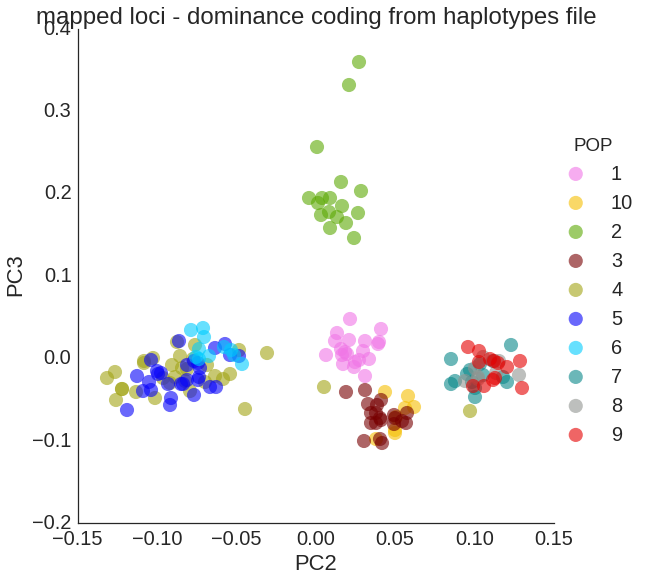

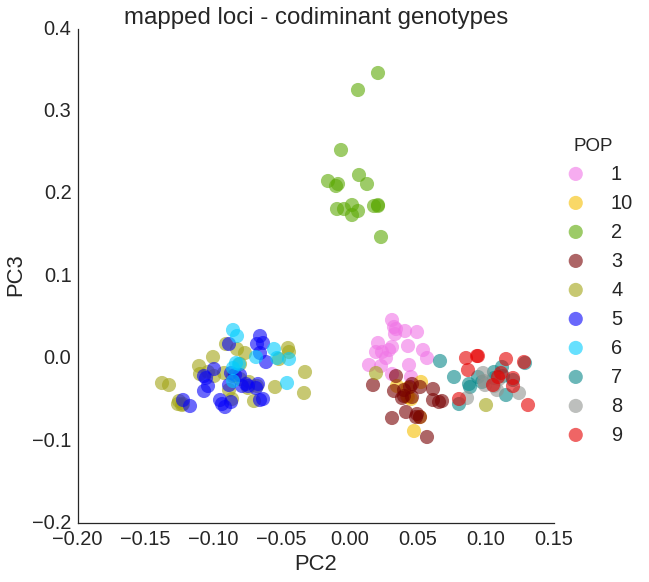

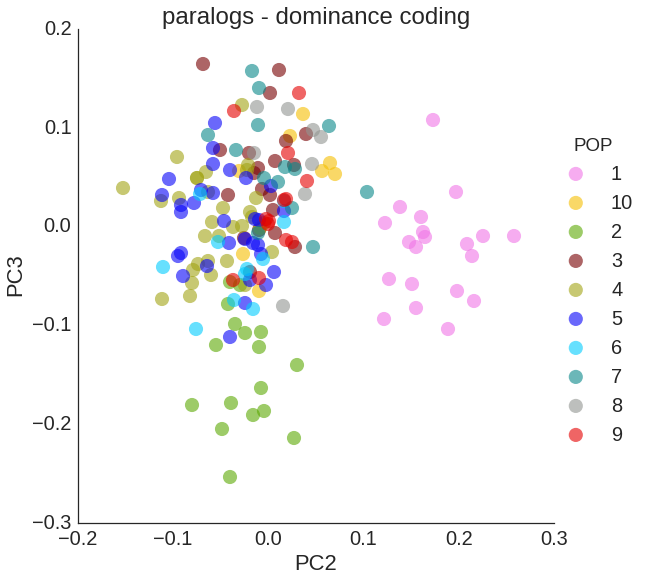

In [21]:
figsize(10, 10)
sns.lmplot('PC2', 'PC3', data= eigenvec_on_map_dom, hue = 'POP', palette=sns.xkcd_palette(pop_colors),
           fit_reg=False, size = 8, scatter_kws={"s": 200., 'alpha': .6} )
plt.title('mapped loci - dominance coding from haplotypes file')
plt.show()

sns.lmplot('PC2', 'PC3', data= eigenvec_on_map_codom, hue = 'POP', palette=sns.xkcd_palette(pop_colors),
           fit_reg=False, size = 8, scatter_kws={"s": 200., 'alpha': .6} )
plt.title('mapped loci - codiminant genotypes')
plt.show()

sns.lmplot('PC2', 'PC3', data= eigenvec_paralogs, hue = 'POP', palette=sns.xkcd_palette(pop_colors),
           fit_reg=False, size = 8, scatter_kws={"s": 200., 'alpha': .6} )
plt.title('paralogs - dominance coding')
plt.show()

### TODO 
   * look at evalues - include on plots
   * down sample to same number of loci
   * population names